# Classification & Interpretation

## Copyright notice

This version (c) 2020 Fabian Offert, [MIT License](LICENSE).

## Imports

We are using the PyTorch as our deep learning framework.

In [1]:
import sys
sys.path.append('lib/')
from vc_toolbox import *

import numpy as np

import torch as t
import torchvision as tv
import torch.nn as nn

## Hyperparameters

The model that we chose needs a specific image input size to work. Also, we set a batch size to enable stochastic gradient descent.

In [2]:
input_size = 224
batch_size = 32

We need to check if we have a GPU with CUDA at our disposal.

In [3]:
device = t.device("cuda" if t.cuda.is_available() else "cpu")
print(device)

cuda


## Loading data

90% of machine learning work is data compilation and ingestion. Machine learning models need standardized inputs to work. Here we standardize, and at the same time augment the WGA dataset.

In [70]:
train_transforms = tv.transforms.Compose([tv.transforms.RandomResizedCrop(input_size),
                                       tv.transforms.RandomHorizontalFlip(),
                                       tv.transforms.ToTensor(),
                                       tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                       ])

val_transforms = tv.transforms.Compose([tv.transforms.Resize(input_size),
                                     tv.transforms.CenterCrop(input_size),
                                     tv.transforms.ToTensor(),
                                     tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

test_transforms = tv.transforms.Compose([tv.transforms.Resize(input_size),
                                     tv.transforms.CenterCrop(input_size),
                                     tv.transforms.ToTensor(),
                                     tv.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

train_data = tv.datasets.ImageFolder('wga/train', transform=train_transforms)
val_data = tv.datasets.ImageFolder('wga/val', transform=val_transforms)
test_data = tv.datasets.ImageFolder('wga/val', transform=test_transforms) # We are testing on validation data, which is kind of a no-no!

trainloader = t.utils.data.DataLoader(train_data, batch_size=batch_size)
valloader = t.utils.data.DataLoader(val_data, batch_size=batch_size)
testloader = t.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

dataloaders = {'train': trainloader, 'val': valloader, 'test': testloader}
class_names = train_data.classes
print(class_names)

['landscape', 'portrait']


## Prepare model for fine-tuning

We are not training from scratch, so we need to load pre-trained weights for a model and change its architecture to correspond to our WGA dataset.

In [23]:
# Hyperparameters
epochs = 5
num_classes = 2
lr=0.0001 # Finetuning: 0.001
feature_extracting = True

model = tv.models.vgg19(pretrained=True) # Load pre-trained weights

# Set all parameters constant
if feature_extracting:
    for param in model.parameters():
        param.requires_grad = False

# Replace prediction layer with new (trainable) layer
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes) # VGG19

# Set up for feature extraction
params_to_update = model.parameters()
if feature_extracting:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)

# Define training components
criterion = nn.CrossEntropyLoss() # https://pytorch.org/docs/stable/nn.html#crossentropyloss
optimizer = t.optim.SGD(params_to_update, lr=lr, momentum=0.9) # Not all parameters are being optimized!

# Move model to device
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## Train

In [24]:
model = train_model(model, dataloaders, criterion, optimizer, device, epochs)
t.save(model, f'model.pth')

Epoch 0/4
----------
train loss: 0.4496 Acc: 0.8020
val loss: 0.4482 Acc: 0.7500
Epoch 1/4
----------
train loss: 0.2939 Acc: 0.8780
val loss: 0.1067 Acc: 0.9650
Epoch 2/4
----------
train loss: 0.1396 Acc: 0.9540
val loss: 0.1015 Acc: 0.9650
Epoch 3/4
----------
train loss: 0.1288 Acc: 0.9585
val loss: 0.0988 Acc: 0.9550
Epoch 4/4
----------
train loss: 0.1254 Acc: 0.9620
val loss: 0.0972 Acc: 0.9550
Best val acc: 0.965000


In [7]:
# Load previously saved model
# model = t.load('model.pth')

## Testing and visualizing what the model has learned

Let's see how well this has workd by visualizing a couple of inputs and their respective predictions.

In [73]:
def visualize_model(model, class_names, num_images):
    
    was_training = model.training
    model.eval()
    images_so_far = 0

    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = t.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            
            title = f'Ground truth: {class_names[labels.data[j]]}, Prediction: {class_names[preds[j]]}'

            print(title)
            show_img(inputs[j], normalize=True)
            
            if images_so_far == num_images:
                model.train(mode=was_training)
                return

    model.train(mode=was_training)

Ground truth: portrait, Prediction: portrait


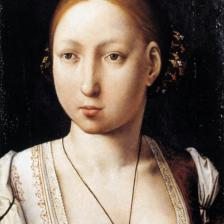

Ground truth: landscape, Prediction: portrait


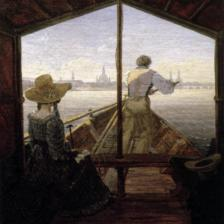

Ground truth: portrait, Prediction: portrait


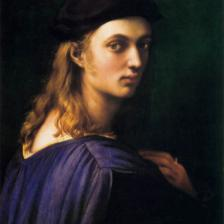

Ground truth: landscape, Prediction: landscape


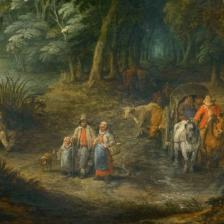

Ground truth: portrait, Prediction: portrait


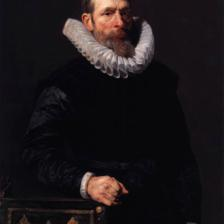

Ground truth: landscape, Prediction: landscape


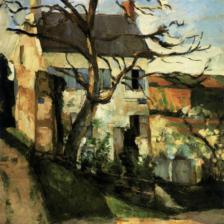

Ground truth: portrait, Prediction: portrait


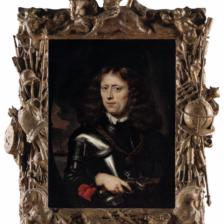

Ground truth: portrait, Prediction: portrait


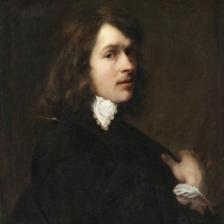

Ground truth: portrait, Prediction: portrait


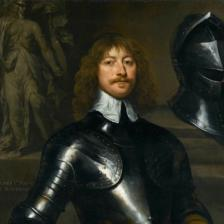

Ground truth: portrait, Prediction: portrait


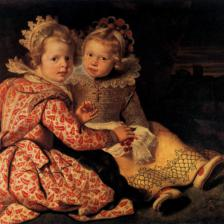

In [74]:
visualize_model(model, class_names, 10)